In [11]:
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1+cp.exp(-x))

#sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

In [5]:
# convert X, Y to CuPy arrays

X = cp.array(X)
Y = cp.array(Y)

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    500,
    100,
    10
]

In [7]:
# initialize parameters

W1 = cp.random.randn(layer_sizes[1], layer_sizes[0])
b1 = cp.zeros((layer_sizes[1], 1))

W2 = cp.random.randn(layer_sizes[2], layer_sizes[1])
b2 = cp.zeros((layer_sizes[2], 1))

W3 = cp.random.randn(layer_sizes[3], layer_sizes[2])
b3 = cp.zeros((layer_sizes[3], 1))

In [8]:
# train the model

iterations = 1#2500
print_cost = True

samples = X.shape[1] # number of training samples (60000 here)

learning_rate = 0.0000001

cost = .0

for i in range(iterations):

    # forward propagation
    #   push icput data through the network
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = cp.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # MSE
    #   cost function, to compute the error
    cost = cp.sum(cp.power(Y - A3, 2.)) / samples
    # cost = -1 / samples * sum([Y[0][i] * cp.log(A3[0][i]) + (1 - Y[0][i]) * cp.log(1 - AL[0][i]) for i in range(AL.shape[1])])

    if print_cost and i % 5 == 0:
        print('Cost: {} @ i = {}'.format(cost, i))


    # backward propagation
    #   adjust the weights and biases to fit the data

    # compute the derivatives of the weights and biases
    # dW3
    dA3 = 2 * (Y - A3)
    dZ3 = sigmoid_d(A3)
    dW3 = cp.dot(dA3 * dZ3, A2.T)
    db3 = cp.sum(dZ3, axis=1, keepdims=True)

    # dW2
    dA2 = cp.dot(W3.T, dA3 * dZ3)
    dZ2 = sigmoid_d(A2)
    dW2 = cp.dot(dA2 * dZ2, A1.T)
    db2 = cp.sum(dZ2, axis=1, keepdims=True)

    # dW1
    dA1 = cp.dot(W2.T, dA2 * dZ2)
    dZ1 = sigmoid_d(A1)
    dW1 = cp.dot(dA1 * dZ1, X.T)
    db1 = cp.sum(dZ1, axis=1, keepdims=True)


    # update parameters
    W1 += learning_rate * dW1
    W2 += learning_rate * dW2
    W3 += learning_rate * dW3

    b1 += learning_rate * db1
    b2 += learning_rate * db2
    b3 += learning_rate * db3

Cost: 4.044418288229088 @ i = 0


[[0.9990741 ]
 [0.00405753]
 [0.35959688]
 [0.99998497]
 [0.99653667]
 [0.08951429]
 [0.32043492]
 [0.50920071]
 [0.30549841]
 [0.00678271]]


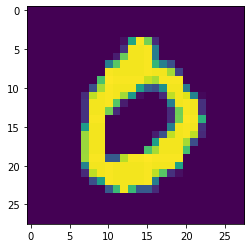

In [13]:
# load a sample image from the test dataset
# to evaluate the model

img = np.asarray(
        Image.open(
            dataset_path + "/testing/0/3.png"
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# ro CuPy
X_n = cp.array(X_n)

In [19]:
# predict

def predict(X):
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = cp.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    return A3


In [20]:
# validate

Y_prediction_train = predict(cp.array(dataset['train']['X']))
Y_train = cp.array(dataset['train']['Y'])

Y_prediction_test = predict(cp.array(dataset['test']['X']))
Y_test = cp.array(dataset['test']['Y'])

print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

train accuracy: 55.440514335389736 %
test accuracy: 55.24193296526562 %
